In [1]:
import pandas as pd
import os
import re
import sys
import numpy as np
from merf import MERF
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 
sns.set_context("poster")
from sklearn.ensemble import RandomForestRegressor
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (11,8)
from merf.merf import MERF
from sklearn.model_selection import train_test_split, KFold
from merf.viz import plot_merf_training_stats

current_dir = os.getcwd() # Get the current working directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
from em_utils import *

# Create output directory if it doesn't exist
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/6.two_timepoints_delta"
df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/6.two_timepoints_deltas"
os.makedirs(output_dir, exist_ok=True)

m1_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/zachs_rerun/drift_fs/csv/all_omic_processed_data/deltas/"
test = read_data(m1_dir, "jan30_all_delta_test_imp_varcheck.csv")
train = read_data(m1_dir, "jan30_all_delta_train_imp_varcheck.csv")

In [2]:
columns_to_drop = ['Weight', 'CRP', 'ghrelin','leptin']
train = train.drop([col for col in columns_to_drop if col in train.columns], axis=1)
test = test.drop([col for col in columns_to_drop if col in test.columns], axis=1)

print("test shape = ", test.shape)
print("train shape = ", train.shape)

test = test.dropna()
train = train.dropna()

print("test shape = ", test.shape)
print("train shape = ", train.shape)

test shape =  (62, 916)
train shape =  (234, 916)
test shape =  (62, 916)
train shape =  (234, 916)


In [3]:
print("---------- Select predictors for training set ----------")
train_set = train
X = train_set.drop(['BMI', 'subject_id', 'range'], axis=1)
Y = train_set[['BMI']]
Y = Y['BMI'].to_numpy() # Convert Y to numeric array
clusters_train = train_set['subject_id'].to_numpy() # Get ID variables
Z = np.ones((train_set.shape[0], 1)) # Create random effects matrix with ones

print("X shape: ", X.shape)
print("X data: \n", X)

print("---------- Select predictors for test set ----------")
test_set = test
X_new = test_set.drop(['BMI', 'subject_id', 'range'], axis=1)
X_new = X_new[X.columns]  # Reorder and select columns to match training set
X_new = X_new.astype(X.dtypes)  # Ensure data types match

Y_new = test_set['BMI'].to_numpy()  # Convert Y to numeric array
clusters_new = pd.Series(test_set['subject_id'])  # Convert to pandas Series
Z_new = np.ones((len(X_new), 1))

print("X_new shape: ", X_new.shape)
print("X_new data: \n", X_new)

---------- Select predictors for training set ----------
X shape:  (234, 913)
X data: 
      randomized_group        age  sex  race  cholesterol       HDL       LDL  \
0                   0  55.245374    0     5    -0.278162 -1.013848  0.159223   
1                   1  39.362775    0     5     0.066751  0.074411 -0.009366   
2                   0  29.654385    0     5    -1.509993 -1.195225 -0.290347   
3                   1  53.022307    0     2    -0.918714  0.799917 -0.964702   
4                   0  28.712545    0     7     0.707303  0.074411  0.664989   
..                ...        ...  ...   ...          ...       ...       ...   
229                 1  52.696382    1     2     1.249309  1.525423  0.833577   
230                 1  28.728744    1     5     0.263844 -0.469719  1.114559   
231                 1  55.825810    0     5     0.756576 -0.469719  1.002166   
232                 0  47.138545    0     5     0.066751  0.074411 -0.009366   
233                 1  42.155554

### Read in fine tuning params

In [4]:
df = pd.read_csv(os.path.join(df_dir, 'jan30_2times_all_omic_deltas_BMI_remove_time_var_imputed_swapped.csv'))

# the line below filters out certain folds
# df = df[df['n_splits'] == 5]

# Find the row with the lowest mean_mse_score
lowest_mse_row = df.loc[df['mean_mse_score'].idxmin()]
print("First 5 columns for the lowest mean_mse_score:")
print(lowest_mse_row.iloc[:5])

# Find the row with the lowest mean_prev_score
lowest_prev_row = df.loc[df['mean_prev'].idxmin()]
print("First 5 columns for the lowest mean_prev_score:")
print(lowest_prev_row.iloc[:5])

# Find the row with the lowest mean_prev_score
lowest_ptev_row = df.loc[df['mean_ptev'].idxmin()]
print("First 5 columns for the lowest mean_ptev_score:")
print(lowest_ptev_row.iloc[:5])

# Find the row with the highest oob_score
highest_oob_row = df.loc[df['oob_score'].idxmax()]
print("\nFirst 5 columns for the highest oob_score:")
print(highest_oob_row.iloc[:5])

First 5 columns for the lowest mean_mse_score:
n_estimators         500.0
max_depth              NaN
min_samples_split      0.1
max_iter              10.0
n_splits              10.0
Name: 29, dtype: float64
First 5 columns for the lowest mean_prev_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter                2.00
n_splits                3.00
Name: 36, dtype: float64
First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits              10.00
Name: 14, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter              10.00
n_splits               3.00
Name: 21, dtype: float64


### Take a look at all the parameters 

In [5]:
# Extract the rows for the parameter grids
lowest_mse_row = df.loc[df['mean_mse_score'].idxmin()]
lowest_prev_row = df.loc[df['mean_prev'].idxmin()]
lowest_ptev_row = df.loc[df['mean_ptev'].idxmin()]
highest_oob_row = df.loc[df['oob_score'].idxmax()]

# Create parameter grids from the extracted rows
best_mse_param_grid = {
    'n_estimators': [int(lowest_mse_row['n_estimators'])],
    #'max_depth': [int(lowest_mse_row['max_depth'])],
    'max_depth': [None if pd.isna(lowest_mse_row['max_depth']) else int(lowest_mse_row['max_depth'])],
    'min_samples_split': [float(lowest_mse_row['min_samples_split'])],
    #'min_samples_split': [float(lowest_mse_row['min_samples_split']) if lowest_mse_row['min_samples_split'] != 0 else 0.0],  # Convert 0 to 0.0
    'max_iter': [int(lowest_mse_row['max_iter'])],
    'n_splits': [int(lowest_mse_row['n_splits'])]
}
print("Best MSE Parameter Grid:")
print("n_estimators:", best_mse_param_grid['n_estimators'][0])
print("max_depth:", best_mse_param_grid['max_depth'][0])
print("min_samples_split:", best_mse_param_grid['min_samples_split'][0])
print("max_iter:", best_mse_param_grid['max_iter'][0])
print("n_splits:", best_mse_param_grid['n_splits'][0])

lowest_prev_param_grid = {
    'n_estimators': [int(lowest_prev_row['n_estimators'])],
    #'max_depth': [int(lowest_prev_row['max_depth'])],
    'max_depth': [None if pd.isna(lowest_prev_row['max_depth']) else int(lowest_prev_row['max_depth'])],
    'min_samples_split': [float(lowest_prev_row['min_samples_split'])],
    'max_iter': [int(lowest_prev_row['max_iter'])],
    'n_splits': [int(lowest_prev_row['n_splits'])]
}
print("\nLowest Prev Parameter Grid:")
print("n_estimators:", lowest_prev_param_grid['n_estimators'][0])
print("max_depth:", lowest_prev_param_grid['max_depth'][0])
print("min_samples_split:", lowest_prev_param_grid['min_samples_split'][0])
print("max_iter:", lowest_prev_param_grid['max_iter'][0])
print("n_splits:", lowest_prev_param_grid['n_splits'][0])

lowest_ptev_param_grid = {
    'n_estimators': [int(lowest_ptev_row['n_estimators'])],
    #'max_depth': [int(lowest_ptev_row['max_depth'])],
    'max_depth': [None if pd.isna(lowest_ptev_row['max_depth']) else int(lowest_ptev_row['max_depth'])],
    'min_samples_split': [float(lowest_ptev_row['min_samples_split'])],
    'max_iter': [int(lowest_ptev_row['max_iter'])],
    'n_splits': [int(lowest_ptev_row['n_splits'])]
}
print("\nLowest PTEV Parameter Grid:")
print("n_estimators:", lowest_ptev_param_grid['n_estimators'][0])
print("max_depth:", lowest_ptev_param_grid['max_depth'][0])
print("min_samples_split:", lowest_ptev_param_grid['min_samples_split'][0])
print("max_iter:", lowest_ptev_param_grid['max_iter'][0])
print("n_splits:", lowest_ptev_param_grid['n_splits'][0])

highest_oob_param_grid = {
    'n_estimators': [int(highest_oob_row['n_estimators'])],
    'max_depth': [None if pd.isna(highest_oob_row['max_depth']) else int(highest_oob_row['max_depth'])],
    'min_samples_split': [float(highest_oob_row['min_samples_split'])],
    'max_iter': [int(highest_oob_row['max_iter'])],
    'n_splits': [int(highest_oob_row['n_splits'])]
}
print("\Highest OOB Parameter Grid:")
print("n_estimators:", highest_oob_row['n_estimators'])
print("max_depth:", highest_oob_row['max_depth'])
print("min_samples_split:", highest_oob_row['min_samples_split'])
print("max_iter:", highest_oob_row['max_iter'])
print("n_splits:", highest_oob_row['n_splits'])

Best MSE Parameter Grid:
n_estimators: 500
max_depth: None
min_samples_split: 0.1
max_iter: 10
n_splits: 10

Lowest Prev Parameter Grid:
n_estimators: 1000
max_depth: None
min_samples_split: 0.05
max_iter: 2
n_splits: 3

Lowest PTEV Parameter Grid:
n_estimators: 100
max_depth: None
min_samples_split: 0.15
max_iter: 2
n_splits: 10
\Highest OOB Parameter Grid:
n_estimators: 500.0
max_depth: nan
min_samples_split: 0.05
max_iter: 10.0
n_splits: 3.0


<>:61: SyntaxWarning: invalid escape sequence '\H'
<>:61: SyntaxWarning: invalid escape sequence '\H'
/var/folders/4l/kqxc4rwn4lj10fzv9hw4xxsr0000gn/T/ipykernel_7537/2937010470.py:61: SyntaxWarning: invalid escape sequence '\H'
  print("\Highest OOB Parameter Grid:")


### Set up different merfs 

In [6]:
# Create MERF models for each parameter grid
mse_merf = MERF(fixed_effects_model =
           RandomForestRegressor(n_estimators = best_mse_param_grid['n_estimators'][0], 
                                max_depth = best_mse_param_grid['max_depth'][0], 
                                min_samples_split = best_mse_param_grid['min_samples_split'][0], 
                                n_jobs = 1, 
                                oob_score= True),
            gll_early_stop_threshold=None,
            max_iterations = best_mse_param_grid['max_iter'][0])

prev_merf = MERF(fixed_effects_model =
           RandomForestRegressor(n_estimators = lowest_prev_param_grid['n_estimators'][0], 
                                max_depth = lowest_prev_param_grid['max_depth'][0], 
                                min_samples_split = lowest_prev_param_grid['min_samples_split'][0], 
                                n_jobs = 1, 
                                oob_score= True),
            gll_early_stop_threshold=None,
            max_iterations = lowest_prev_param_grid['max_iter'][0])

ptev_merf = MERF(fixed_effects_model =
           RandomForestRegressor(n_estimators = lowest_ptev_param_grid['n_estimators'][0], 
                                max_depth = lowest_ptev_param_grid['max_depth'][0], 
                                min_samples_split = lowest_ptev_param_grid['min_samples_split'][0], 
                                n_jobs = 1, 
                                oob_score= True),
            gll_early_stop_threshold=None,
            max_iterations = lowest_ptev_param_grid['max_iter'][0])

oob_merf = MERF(fixed_effects_model =
           RandomForestRegressor(n_estimators = highest_oob_param_grid['n_estimators'][0], 
                                max_depth = highest_oob_param_grid['max_depth'][0], 
                                min_samples_split = highest_oob_param_grid['min_samples_split'][0], 
                                n_jobs = 1, 
                                oob_score= True),
            gll_early_stop_threshold=None,
            max_iterations = highest_oob_param_grid['max_iter'][0])

## run Merfs 

In [7]:
print("---------- RUN MERF RAW WITH TUNING PARAMETERS 🌱 ----------")
mrf_mse = mse_merf.fit(X.select_dtypes(include=[np.number]), 
        Z, 
        pd.Series(clusters_train), 
        Y)

mrf_prev = prev_merf.fit(X.select_dtypes(include=[np.number]), 
        Z, 
        pd.Series(clusters_train), 
        Y)

mrf_ptev = ptev_merf.fit(X.select_dtypes(include=[np.number]), 
        Z, 
        pd.Series(clusters_train), 
        Y)

mrf_oob = oob_merf.fit(X.select_dtypes(include=[np.number]), 
                Z, 
                pd.Series(clusters_train), 
                Y)

---------- RUN MERF RAW WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 166.50528477338372 at iteration 1.
INFO     [merf.py:307] Training GLL is 189.41408390965935 at iteration 2.
INFO     [merf.py:307] Training GLL is 186.94044227351588 at iteration 3.
INFO     [merf.py:307] Training GLL is 178.28461193305182 at iteration 4.
INFO     [merf.py:307] Training GLL is 172.25874254684118 at iteration 5.
INFO     [merf.py:307] Training GLL is 162.36051870391174 at iteration 6.
INFO     [merf.py:307] Training GLL is 154.85047843633973 at iteration 7.
INFO     [merf.py:307] Training GLL is 141.65972204587047 at iteration 8.
INFO     [merf.py:307] Training GLL is 144.94687399307995 at iteration 9.
INFO     [merf.py:307] Training GLL is 140.52676146839173 at iteration 10.
INFO     [merf.py:307] Training GLL is 58.63340949049525 at iteration 1.
INFO     [merf.py:307] Training GLL is 74.9969359733628 at iteration 2.
INFO     [merf.py:307] Training GLL is 247.5072458982809 at iteration 1.
INFO     [merf.py:307] Training GLL is 25

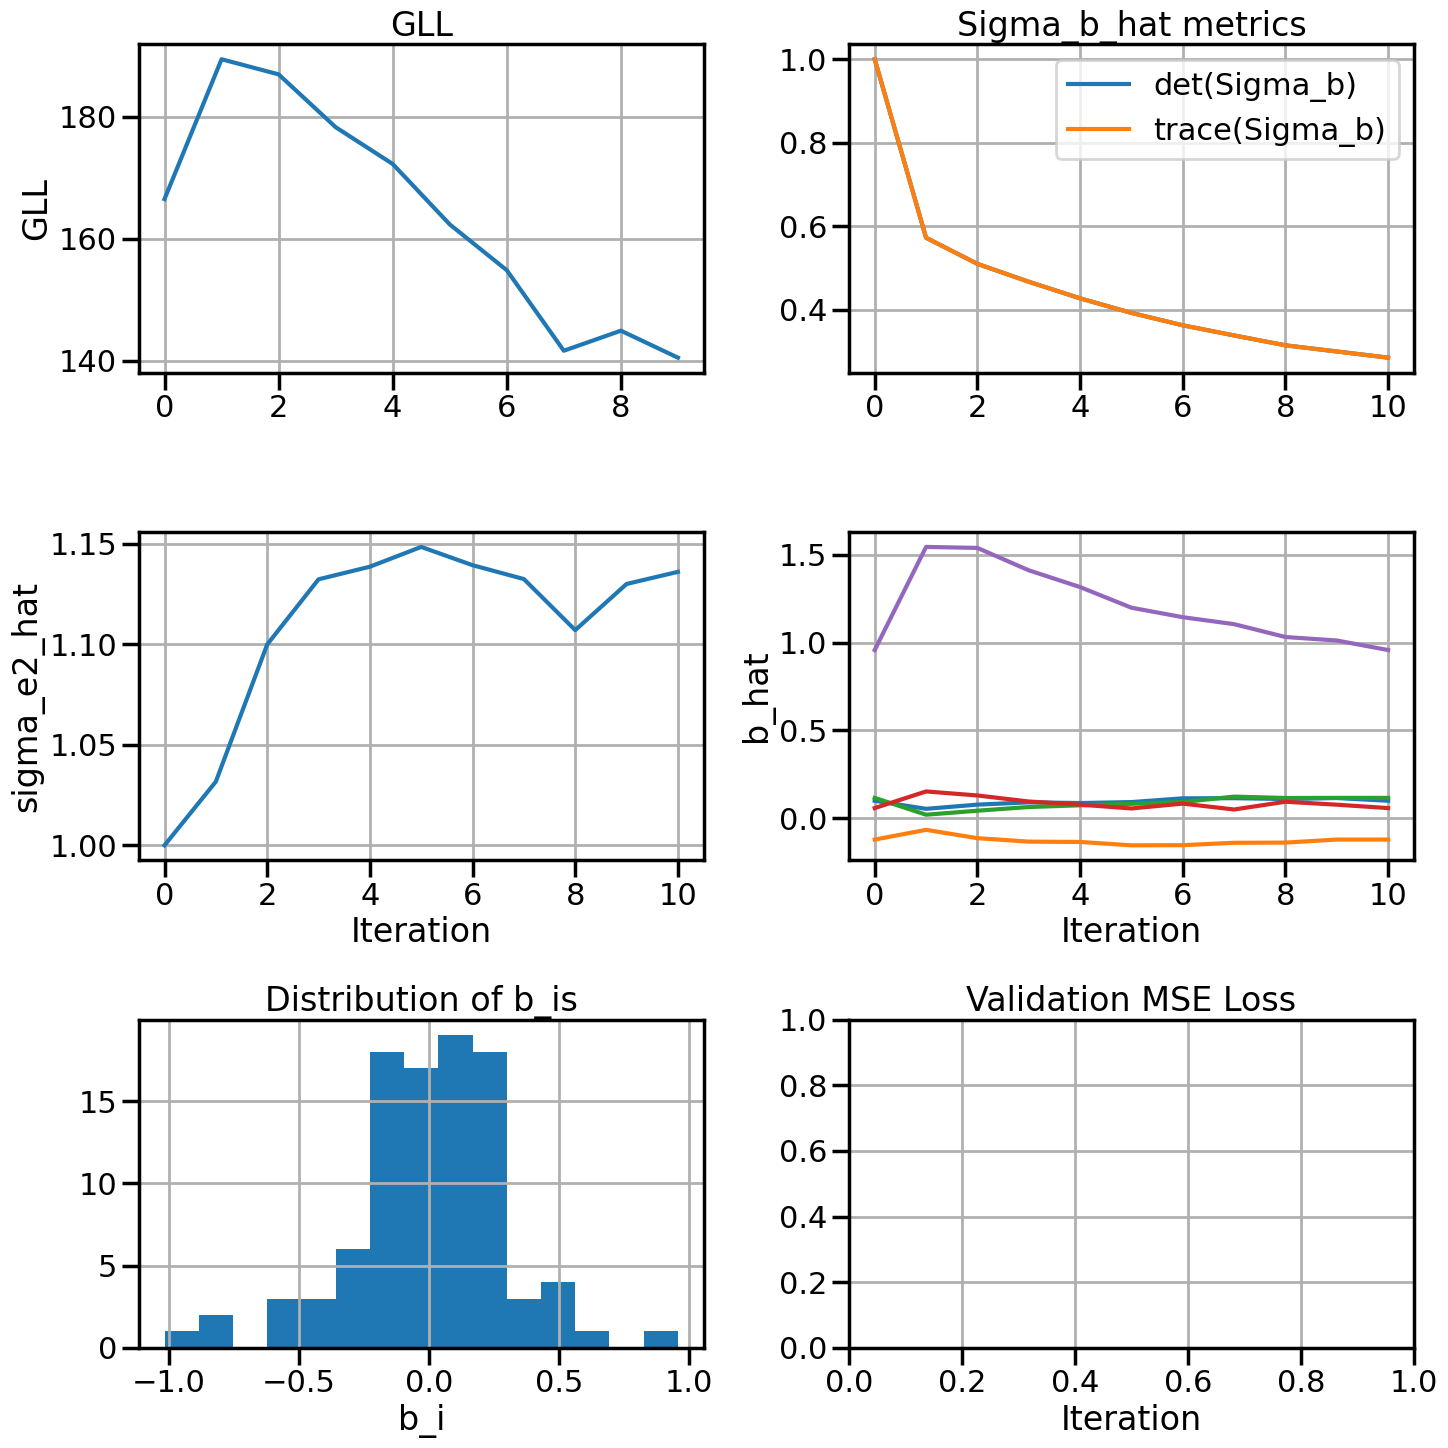

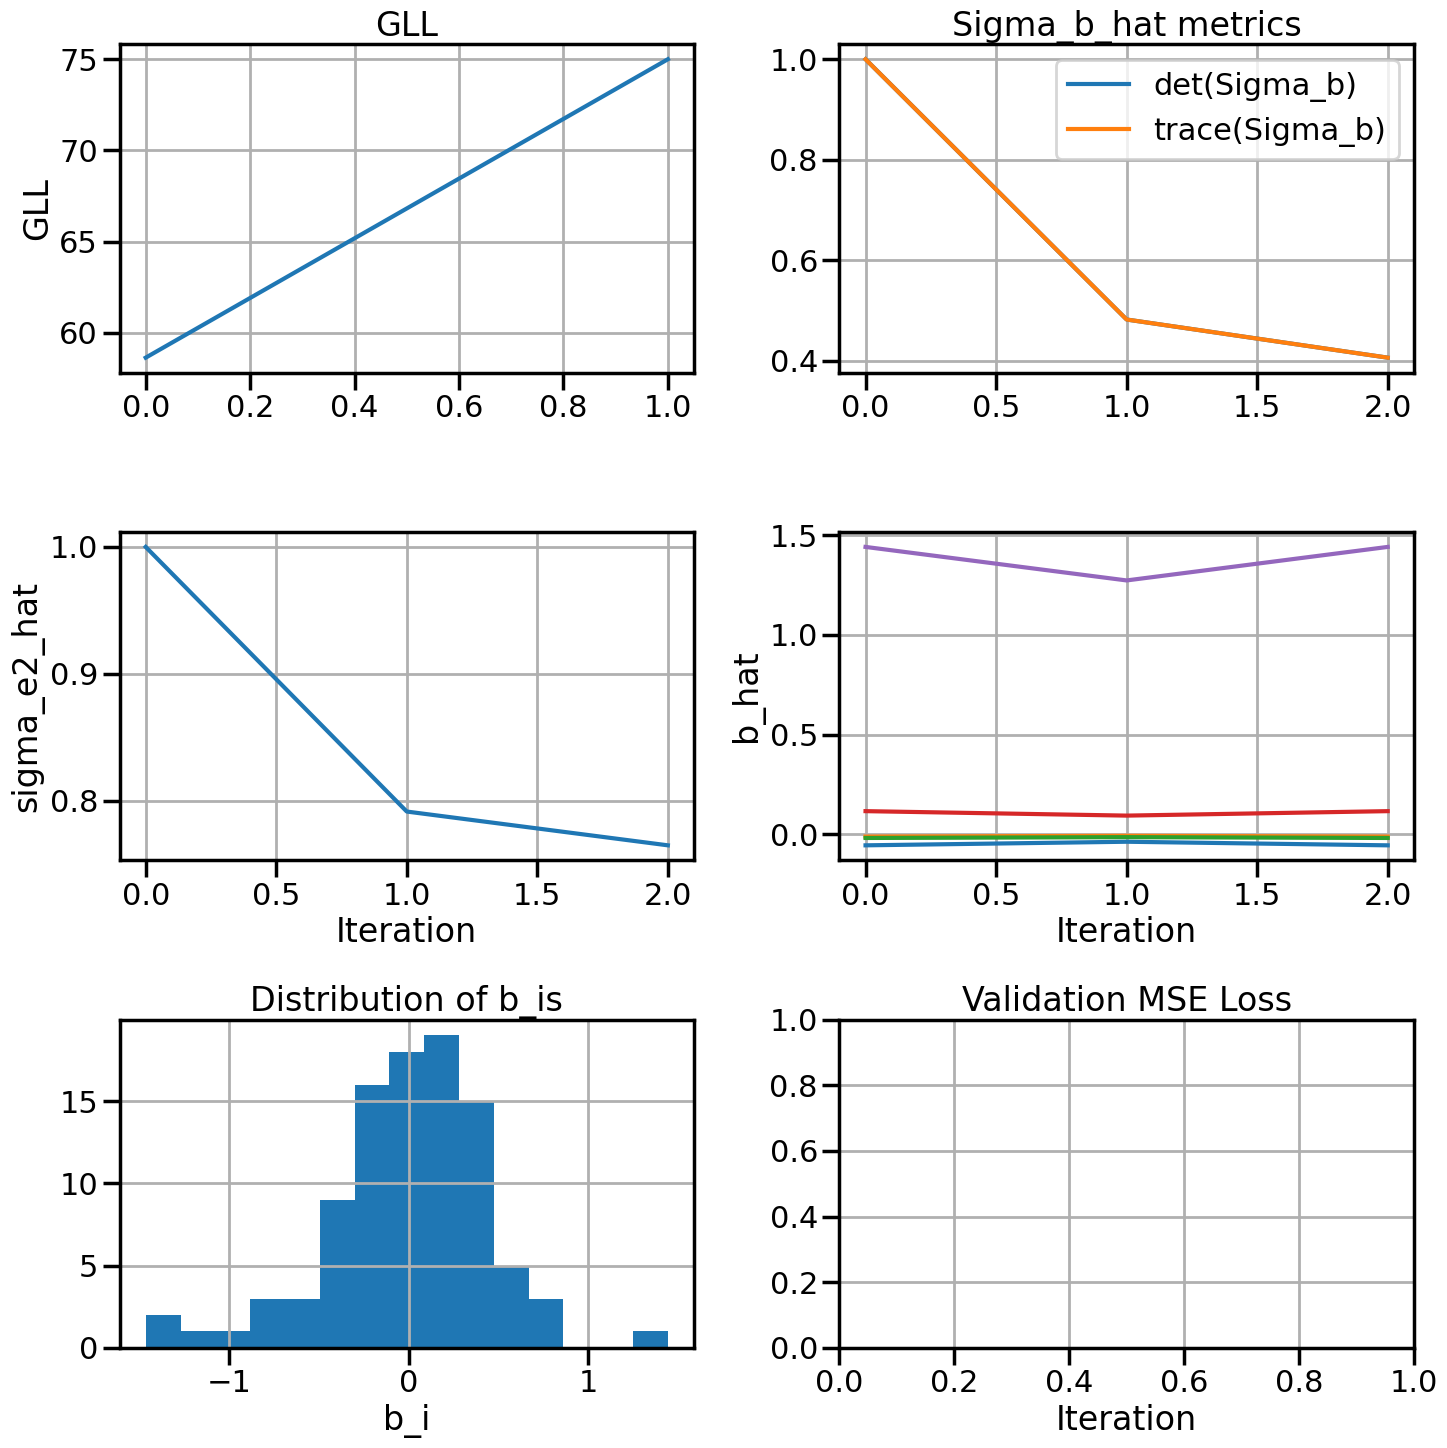

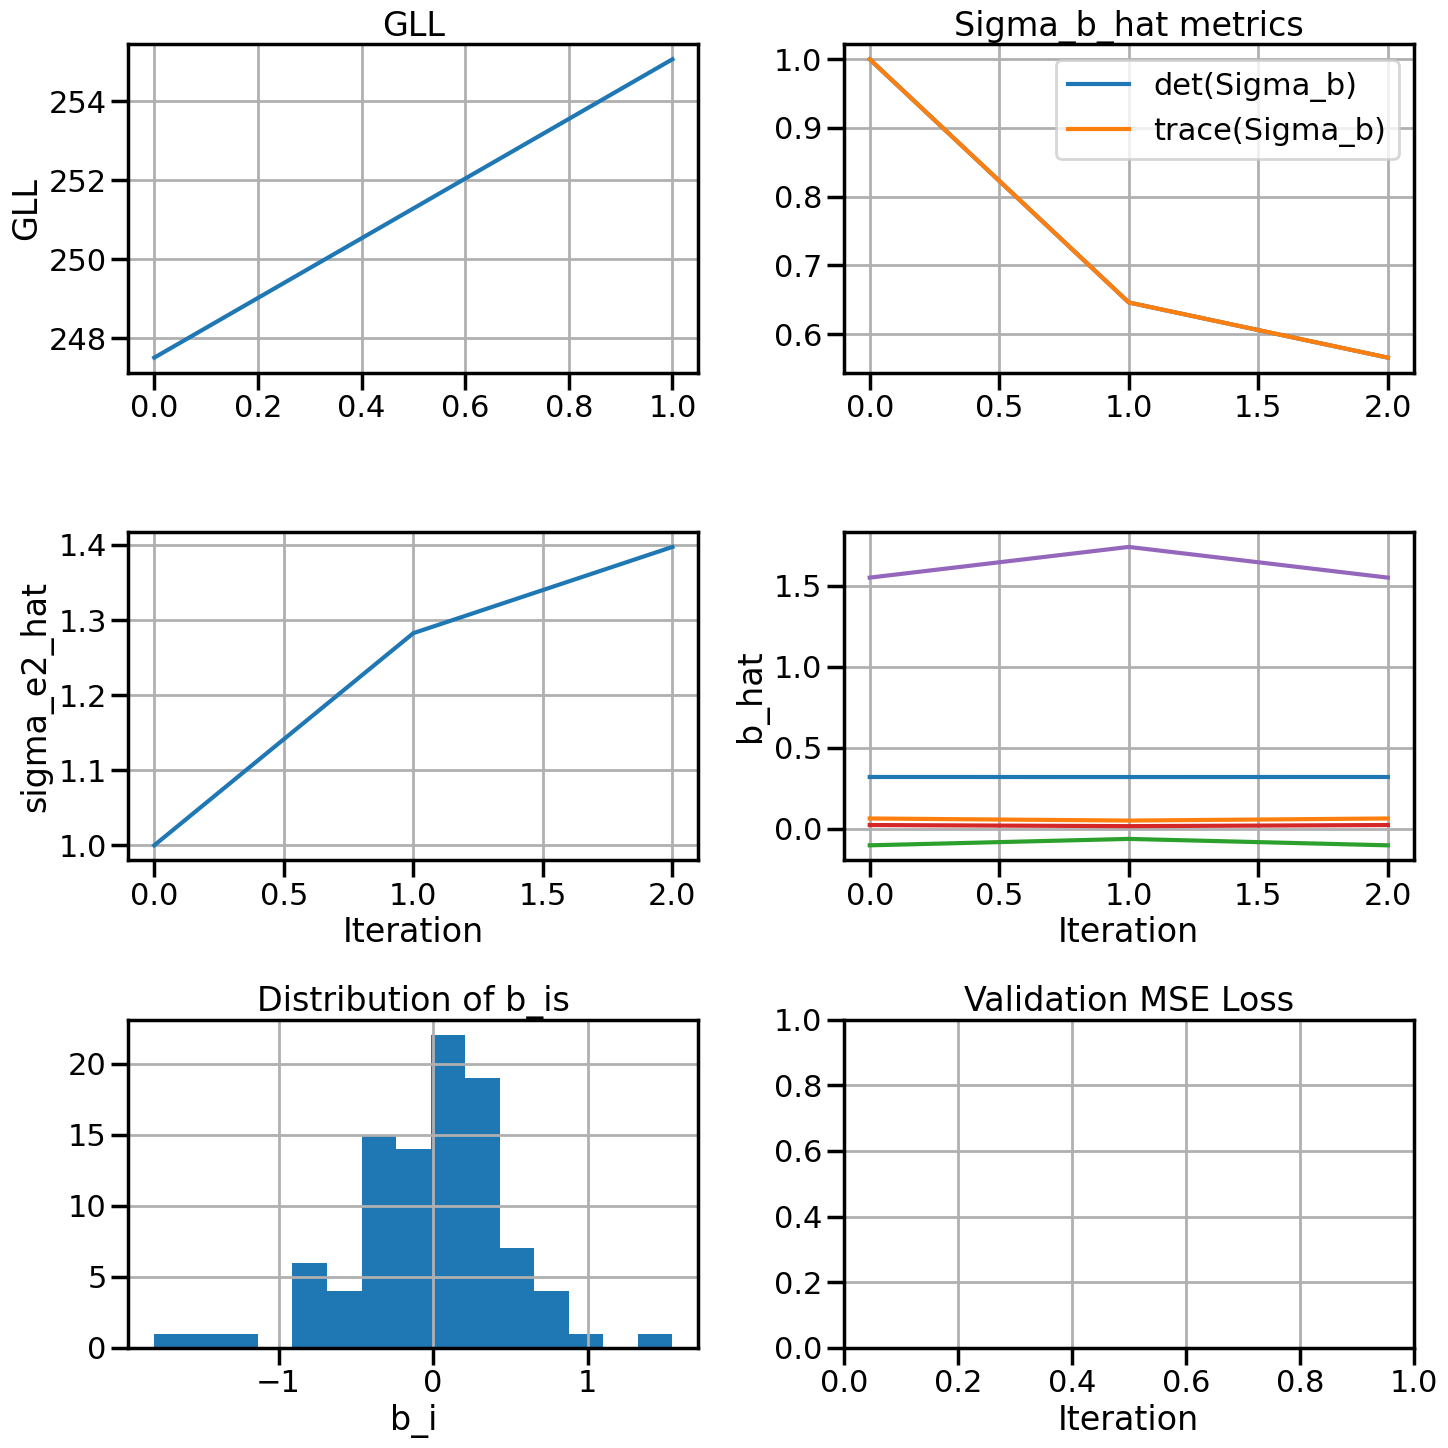

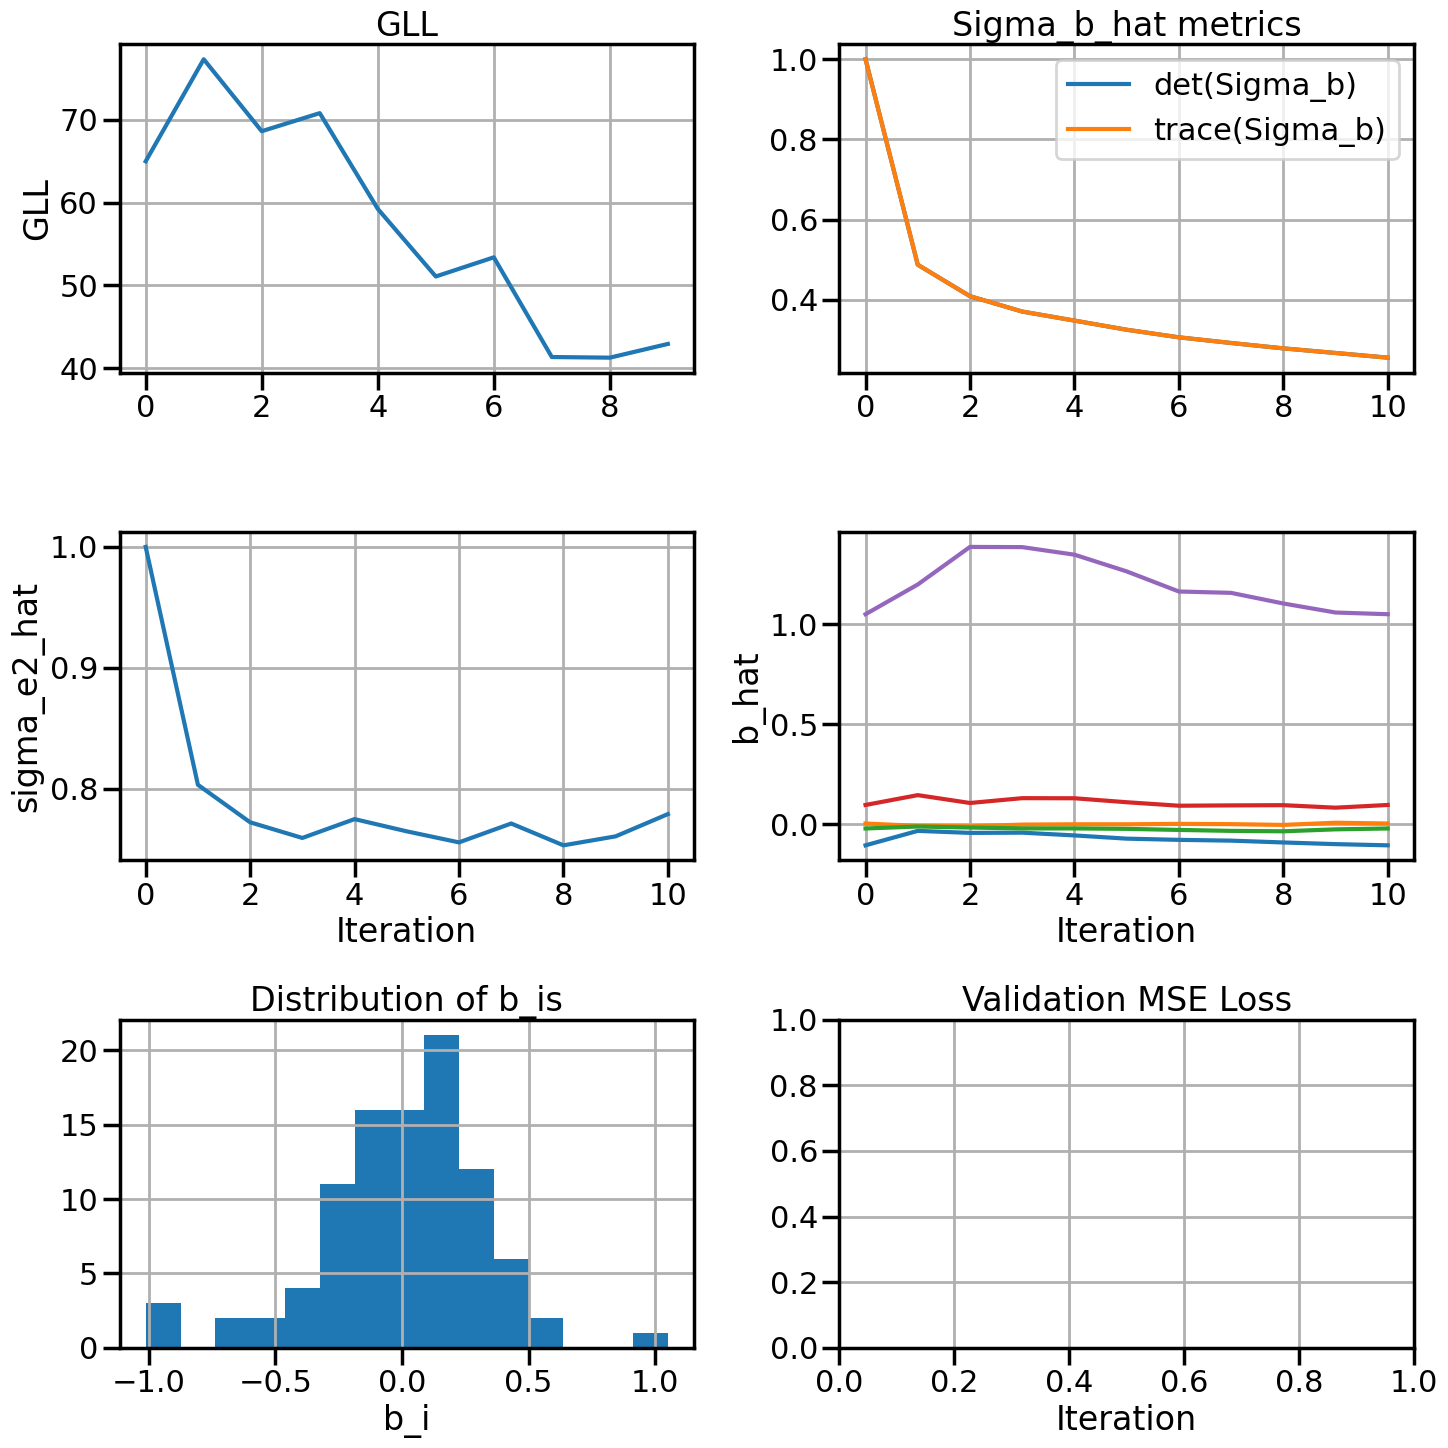

In [8]:
plot_merf_training_stats(mrf_mse)
plt.savefig(os.path.join(output_dir, 'jan31_2time_deltas_tuned_mse_merf_metrics_all.png'), dpi=300, bbox_inches='tight')

plot_merf_training_stats(mrf_prev)
plt.savefig(os.path.join(output_dir, 'jan31_2time_deltas_tuned_prev_merf_metrics_all.png'), dpi=300, bbox_inches='tight')

plot_merf_training_stats(mrf_ptev)
plt.savefig(os.path.join(output_dir, 'jan31_2time_deltas_tuned_ptev_merf_metrics_all.png'), dpi=300, bbox_inches='tight')

plot_merf_training_stats(mrf_oob)
plt.savefig(os.path.join(output_dir, 'jan31_2time_deltas_tuned_oob_merf_metrics_all.png'), dpi=300, bbox_inches='tight')

### Make predictions using fitted models 

In [9]:
# Predict using the fitted model
clusters_new = pd.Series(test_set['subject_id'])
X_new = test_set.drop(['BMI', 'subject_id', 'range'], axis=1)
y_hat_new_mse = mrf_mse.predict(X_new, Z_new, clusters_new)
forest_mse = mrf_mse.trained_fe_model
oob_score_mse = round(forest_mse.oob_score_*100, 1)

y_hat_new_prev = mrf_prev.predict(X_new, Z_new, clusters_new)
forest_prev = mrf_prev.trained_fe_model
oob_score_prev = round(forest_prev.oob_score_*100, 1)

y_hat_new_ptev = mrf_ptev.predict(X_new, Z_new, clusters_new)
forest_ptev = mrf_ptev.trained_fe_model
oob_score_ptev = round(forest_ptev.oob_score_*100, 1)

y_hat_new_oob = mrf_oob.predict(X_new, Z_new, clusters_new)
forest_oob = mrf_oob.trained_fe_model
oob_score_tuned = round(forest_oob.oob_score_*100, 1)

### Plot predicted vs actual

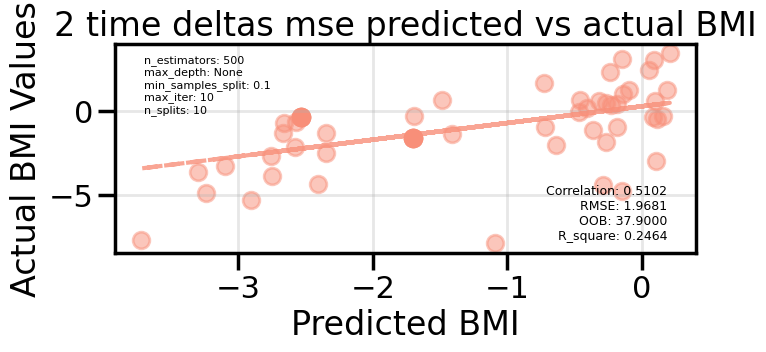

In [10]:
plot_predicted_vs_actual(y_hat_new_mse, Y_new,
                         output_dir, 'jan30_all_predicted_vs_actual_mse_tuned.png', 
                         best_mse_param_grid, oob_score_mse, '#F88F79', '2 time deltas mse predicted vs actual BMI')

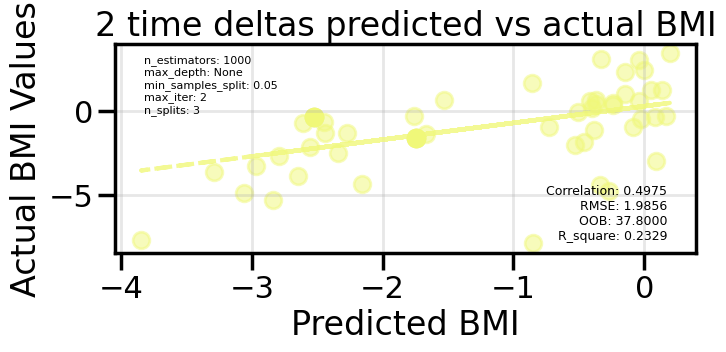

In [11]:
plot_predicted_vs_actual(y_hat_new_prev, Y_new,
                         output_dir, 'jan30_all_predicted_vs_actual_prev_tuned.png', 
                         lowest_prev_param_grid, oob_score_prev, '#F0F879', '2 time deltas predicted vs actual BMI')

Correlation between actual and predicted values: 0.4753
Root Mean Squared Error: 2.0222
R-squared Score: 0.2044


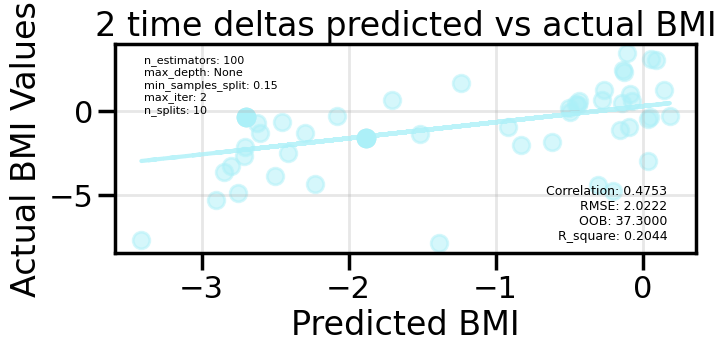

In [12]:
calculate_metrics(Y_new, y_hat_new_ptev) #(Y_true, Y_pred)
plot_predicted_vs_actual(y_hat_new_ptev, Y_new,
                         output_dir, 'jan30_all_predicted_vs_actual_ptev_tuned.png', 
                         lowest_ptev_param_grid, oob_score_ptev, '#ACF0F8', '2 time deltas predicted vs actual BMI')

Correlation between actual and predicted values: 0.4869
Root Mean Squared Error: 2.0101
R-squared Score: 0.2139


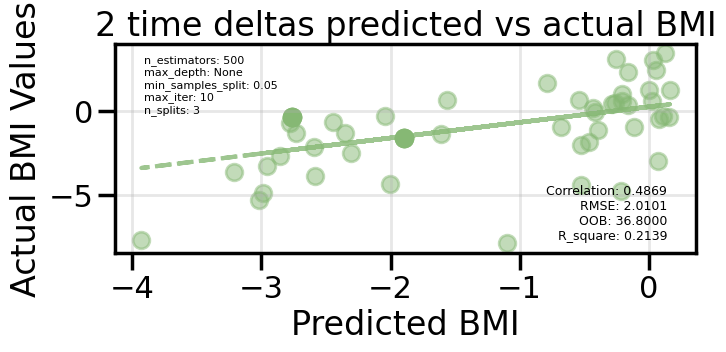

In [13]:
calculate_metrics(Y_new, y_hat_new_oob) #(Y_true, Y_pred)
plot_predicted_vs_actual(y_hat_new_oob, Y_new,
                         output_dir, 'jan30_all_predicted_vs_actual_oob_tuned.png', 
                         highest_oob_param_grid, oob_score_tuned, '#86B874', '2 time deltas predicted vs actual BMI')

### Look at feature importances 

Top 20 ft imp for best MSE parameters:
randomized_group: 0.0017845712468873426
age: 0.00654760419349138
sex: 0.001101987210007147
race: 0.013120925111040444
cholesterol: 0.015015457901310049
HDL: 0.012621935308850673
LDL: 0.012076405818404518
HbA1C: 0.008472919739583673
insulin: 0.08565436439819937
peptide_yy: 0.020060619439341048
tgcyd: 0.07771525039368697
homo_ir: 0.28225259391091423
DENOVOPURINE2-PWY: 0.0
DHGLUCONATE-PYR-CAT-PWY: 0.0
DTDPRHAMSYN-PWY: 0.00013281232409687377
ECASYN-PWY: 0.0
ENTBACSYN-PWY: 0.0001535191873030971
FAO-PWY: 0.0007118407999877184
FASYN-ELONG-PWY: 2.5327323544972775e-05
FASYN-INITIAL-PWY: 0.00012523166378679827


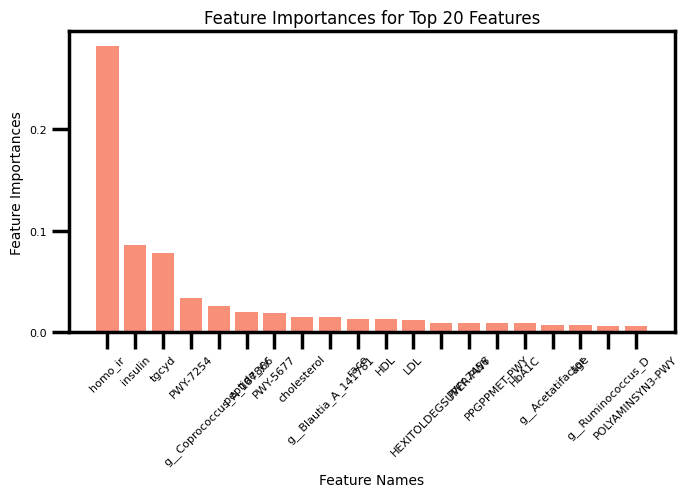

In [14]:
# mse
mse_forest = mrf_mse.trained_fe_model
mse_feature_names = mse_forest.feature_names_in_
mse_feature_importances = mse_forest.feature_importances_

print("Top 20 ft imp for best MSE parameters:")
for name, importance in zip(mse_feature_names[:20], 
                            mse_feature_importances[:20]):
    print(f"{name}: {importance}")

plot_top_20_feature_importances(mse_feature_names, mse_feature_importances, 
                         output_dir, 'jan30_deltas_2time_mse_feature_importances_all', '#F88F79')

Top 20 ft imp for best PREV parameters:
randomized_group: 0.0023628915637016914
age: 0.008995827845538084
sex: 0.0010872839905073318
race: 0.01669122954519651
cholesterol: 0.014961348101913208
HDL: 0.014820076652216551
LDL: 0.011265628467815628
HbA1C: 0.010423309322722847
insulin: 0.06738199232292837
peptide_yy: 0.022073028888880613
tgcyd: 0.07150071889435625
homo_ir: 0.2502184799441373
DENOVOPURINE2-PWY: 0.00021919220656126066
DHGLUCONATE-PYR-CAT-PWY: 0.0
DTDPRHAMSYN-PWY: 0.0004759927626027892
ECASYN-PWY: 0.000100446695683505
ENTBACSYN-PWY: 0.00034073822024545565
FAO-PWY: 0.0014328049781451324
FASYN-ELONG-PWY: 3.474274589091907e-05
FASYN-INITIAL-PWY: 0.00011933313527959833


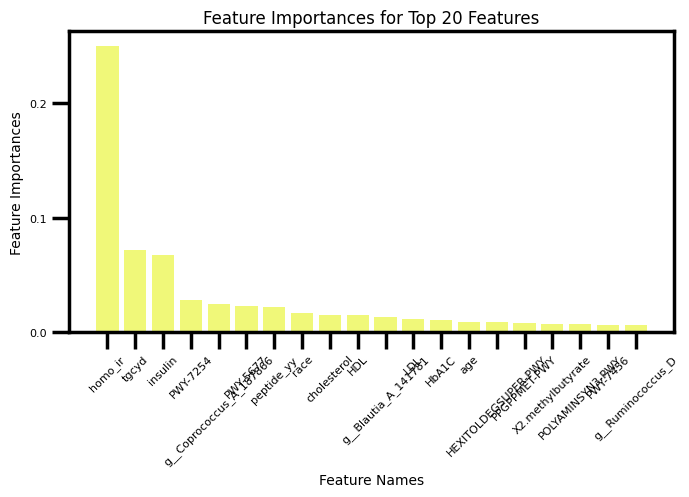

In [15]:
prev_forest = prev_merf.trained_fe_model
prev_feature_names = prev_forest.feature_names_in_
prev_feature_importances = prev_forest.feature_importances_

print("Top 20 ft imp for best PREV parameters:")
for name, importance in zip(prev_feature_names[:20], 
                            prev_feature_importances[:20]):
    print(f"{name}: {importance}")

plot_top_20_feature_importances(prev_feature_names, prev_feature_importances, 
                         output_dir, 'jan30_deltas_2time_prev_feature_importances_all', '#F0F879')

Top 20 feature importances for best PTEV parameters:
randomized_group: 0.0015618255126982911
age: 0.004370585445616686
sex: 0.0010201382181800026
race: 0.0142821167032552
cholesterol: 0.015282063923345298
HDL: 0.011705527711234044
LDL: 0.007536556680041863
HbA1C: 0.007254276749181191
insulin: 0.09557755603115296
peptide_yy: 0.018976192601830942
tgcyd: 0.05695342781932808
homo_ir: 0.3458278888193094
DENOVOPURINE2-PWY: 0.0
DHGLUCONATE-PYR-CAT-PWY: 0.0
DTDPRHAMSYN-PWY: 0.0005071230861840249
ECASYN-PWY: 0.0
ENTBACSYN-PWY: 0.00011355076975872682
FAO-PWY: 0.0022871712479762153
FASYN-ELONG-PWY: 0.0
FASYN-INITIAL-PWY: 0.0


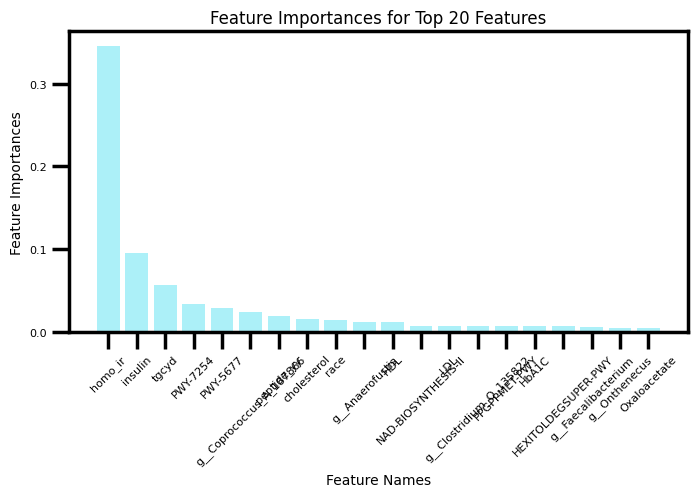

In [16]:
ptev_forest = ptev_merf.trained_fe_model
ptev_feature_names = ptev_forest.feature_names_in_
ptev_feature_importances = ptev_forest.feature_importances_

print("Top 20 feature importances for best PTEV parameters:")
for name, importance in zip(ptev_feature_names[:20], 
                            ptev_feature_importances[:20]):
    print(f"{name}: {importance}")

plot_top_20_feature_importances(ptev_feature_names, ptev_feature_importances, 
                         output_dir, 'jan30__ptev_feature_importances_all', '#ACF0F8')

Top 20 ft imp for best OOB parameters:
randomized_group: 0.002786052963624341
age: 0.009226550399049129
sex: 0.0010784019312171445
race: 0.015771655431546978
cholesterol: 0.01308468873521081
HDL: 0.014053579954047301
LDL: 0.011858784449213953
HbA1C: 0.00960996784270998
insulin: 0.0672806423023337
peptide_yy: 0.022127578993145287
tgcyd: 0.07368522871542861
homo_ir: 0.2562843942616575
DENOVOPURINE2-PWY: 0.00014003562556208162
DHGLUCONATE-PYR-CAT-PWY: 0.0
DTDPRHAMSYN-PWY: 0.00040504551722441546
ECASYN-PWY: 0.00018011722480637947
ENTBACSYN-PWY: 0.00017614469145833472
FAO-PWY: 0.0007403867332120349
FASYN-ELONG-PWY: 0.0001830419511466363
FASYN-INITIAL-PWY: 0.0001590449255554583


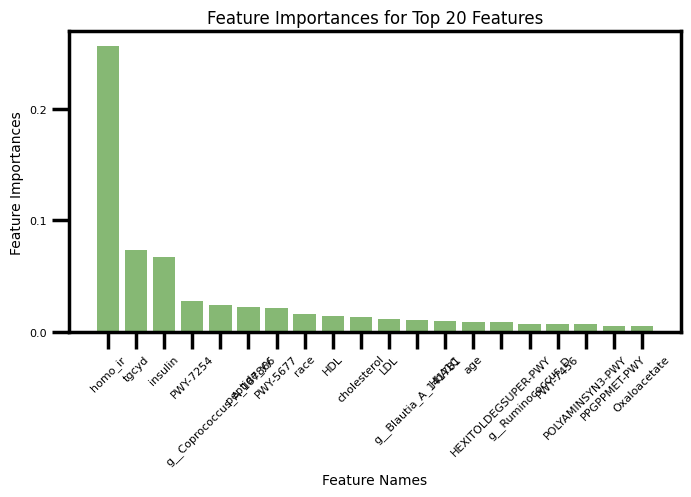

In [17]:
oob_forest = oob_merf.trained_fe_model
oob_feature_names = oob_forest.feature_names_in_
oob_feature_importances = oob_forest.feature_importances_

print("Top 20 ft imp for best OOB parameters:")
for name, importance in zip(oob_feature_names[:20], 
                            oob_feature_importances[:20]):
    print(f"{name}: {importance}")

plot_top_20_feature_importances(oob_feature_names, oob_feature_importances, 
                         output_dir, 'jan30_deltas_2time_oob_feature_importances_all', '#86B874')

### Make merged plots 

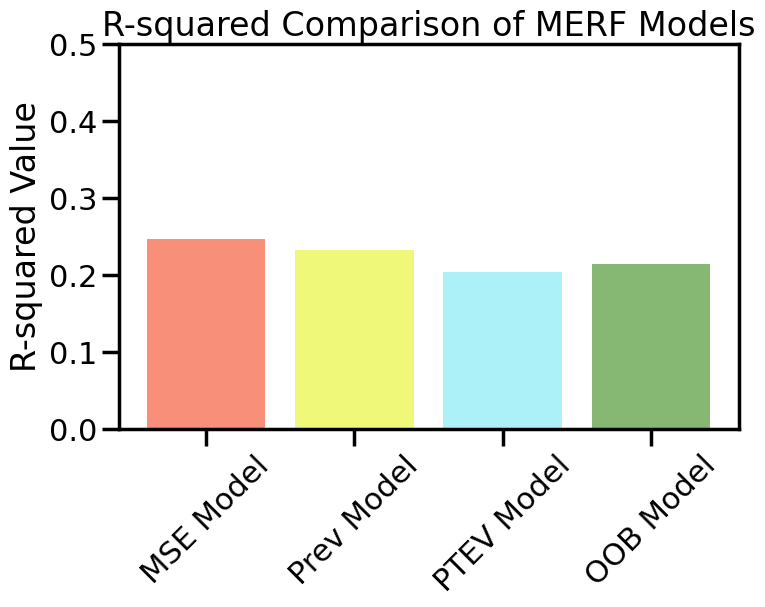

In [21]:
### Calculate R-squared values for each model
from sklearn.metrics import r2_score
color_palette = ['#F88F79', '#F0F879', '#ACF0F8', '#86B874']
# Calculate R-squared for each model
r2_mse = r2_score(Y_new, y_hat_new_mse)
r2_prev = r2_score(Y_new, y_hat_new_prev)
r2_ptev = r2_score(Y_new, y_hat_new_ptev)
r2_oob = r2_score(Y_new, y_hat_new_oob)

# Store R-squared values in a dictionary for plotting
r2_values = {
    'MSE Model': r2_mse,
    'Prev Model': r2_prev,
    'PTEV Model': r2_ptev,
    'OOB Model': r2_oob
}

# Plot R-squared values
plt.figure(figsize=(8, 5))
plt.bar(r2_values.keys(), 
        r2_values.values(), 
        color=color_palette)
plt.ylabel('R-squared Value')
plt.title('R-squared Comparison of MERF Models')
plt.ylim(0, 0.5)
plt.xticks(rotation=45)
plt.savefig(os.path.join(output_dir, 
                         'r_squared_comparison_merf_models.png'), 
                         dpi=300, bbox_inches='tight')
plt.show()

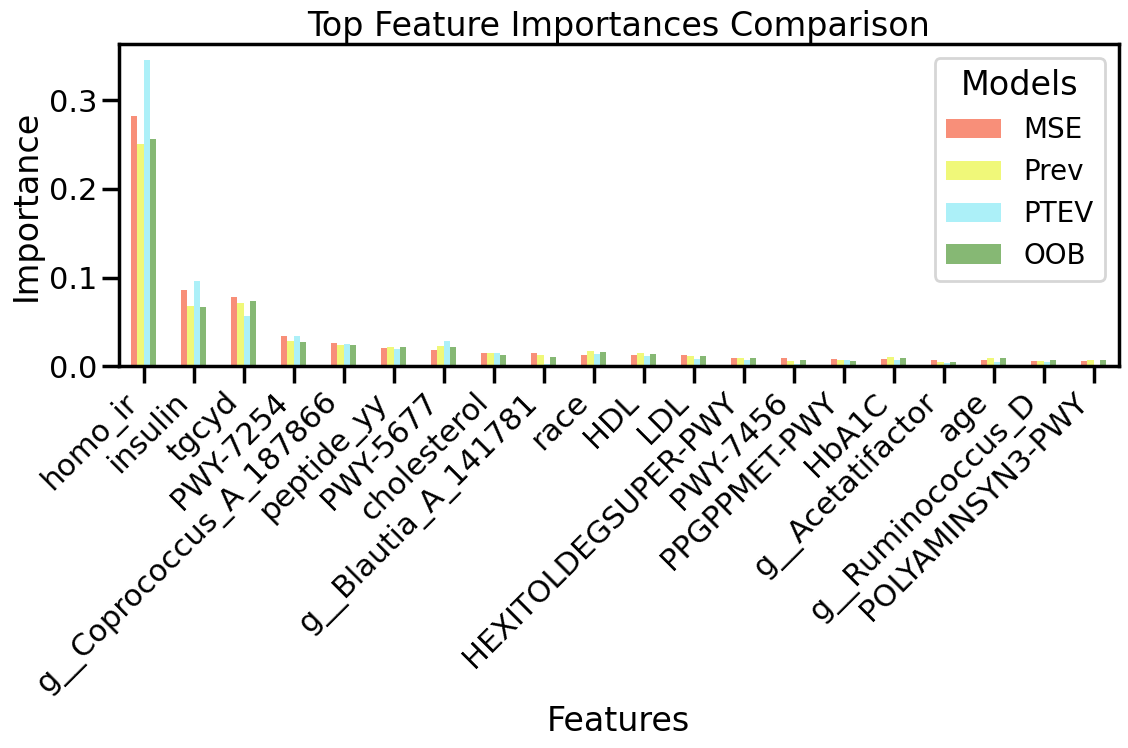

In [36]:
### Compare top feature importances between models
color_palette = ['#F88F79', '#F0F879', '#ACF0F8', '#86B874']
importances = {
    'MSE': mse_feature_importances,
    'Prev': prev_feature_importances,
    'PTEV': ptev_feature_importances,
    'OOB': oob_feature_importances
}

# Create a DataFrame for easier plotting
importances_df = pd.DataFrame(importances, index=mse_feature_names)

# Sort the DataFrame by importance in descending order
importances_df = importances_df.sort_values(by=importances_df.columns.tolist(), ascending=False)

# Plot top feature importances
top_n = 20  # Number of top features to display
importances_df.head(top_n).plot(kind='bar', 
                                figsize=(12, 8),
                                color=color_palette)
plt.title('Top Feature Importances Comparison')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')  # Adjusted rotation and horizontal alignment to reduce overlap
plt.legend(title='Models', 
           loc='upper right', 
           fontsize='small')  # Adjusted legend position to top right corner and made it smaller
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 
                         'top_feature_importances_comparison.png'), 
                         dpi=300, bbox_inches='tight')
plt.show()